In [28]:
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Tuple
import copy
import numpy as np
import random, json, csv, os
import matplotlib.pyplot as plt

In [29]:
train = True
directory_name = 'DOUBLE_Q_Learning_le300k_eps_0.1_gm_0.6_alp_0.06_TD14_500kepcs_1'

In [30]:
ACTIONS = [ "none",
            "attack",
            "scolding",
            "intimidate",
            "grudge",
            "sharing_happiness",
            "happy_person",
            "satisfaction",
            "sharing_fear",
            "running_away",
            "sharing_sadness",
            "disappointment",
            "surprise",
            "disbelief",
            "astonishment"
            ]

            
            
EMOTIONS = ["none",
            "fear",
            "joy",
            "surprise",
            "sadness",
            "anger"
            ]

EMOTION_PER_ACTION = { "none": "none",
            "attack" : "anger",
            "scolding": "anger",
            "intimidate": "anger",
            "grudge": "anger",
            "sharing_happiness": "joy",
            "happy_person": "joy",
            "satisfaction": "joy",
            "sharing_fear": "fear",
            "running_away": "fear",
            "sharing_sadness": "sadness",
            "disappointment": "sadness",
            "surprise": "surprise",
            "disbelief": "surprise",
            "astonishment": "surprise"
}

In [31]:
SCENIC_ACTION_SIZE = len(ACTIONS)
EMOTIONAL_REACTION_SIZE = len(EMOTIONS)

MAXIMUM_SKETCH_LENGTH = 15

In [32]:
# returns the code number of an action given by name
def parse_action(action):
    return ACTIONS.index(action)

#returns the action associated to a code
def unparse_action(code):
    return ACTIONS[code]

# returns the code number of an action given by name
def parse_emotion(action):
    return EMOTIONS.index(action)

#returns the action associated to a code
def unparse_emotion(code):
    return EMOTIONS[code]

def convert_action_into_emo(action):
    return EMOTION_PER_ACTION[action]

In [33]:
class ImprobotEnv(Env):

    def __init__(self, actor_space, robot_space, sketch_lenght, env_matrix, P0):

        self.action_space = Discrete(len(robot_space))
        # environment conditions space
        self.observation_space = Tuple((Discrete(len(robot_space)), Discrete(len(actor_space)))) # (robot reaction, actor action)
        self.state = () # (last robot reaction, last actor action)
        self.initial_action_P = P0
        self.sketch_length = sketch_lenght
        self.counter = 0
        self.P = env_matrix # {action: [probability, actor_action, reward]}
        self.q_table_1 = np.zeros([self.observation_space[0].n, self.observation_space[1].n, self.action_space.n])
        self.q_table_2 = np.zeros([self.observation_space[0].n, self.observation_space[1].n, self.action_space.n])
    
    def render(self):
        print(f"Last actor scenic action: {self.state[1]}")
        print(f"Last robot reaction: {self.state[0]}")

    def step(self, action):
        possible_next_states = self.P[action]
        probabilities = []

        for elem in possible_next_states:
            probabilities.append(elem[0])

        #print(probabilities)
        #print(possible_next_states)
        new_observation_idx = np.random.choice(len(possible_next_states), p=probabilities)
        
        new_observation = possible_next_states[new_observation_idx]
        # update state
        new_reaction = action
        new_actor_action = new_observation[1]
        self.state = tuple([new_reaction, new_actor_action])
        reward = new_observation[2]

        #self.counter += 1

        if self.counter == self.sketch_length:
            done = True
        else:
            done = False

        return self.state, reward, done

    def reset(self):
        actor_action = np.random.choice(SCENIC_ACTION_SIZE,p=self.initial_action_P)
        #print(f"initial action: {actor_action}")
        self.state = (0, actor_action) # (none, none)
        self.counter = 0
        return self.state


In [34]:
# initial action probability distribution
equal_prob = 1/(SCENIC_ACTION_SIZE-1)
P0 = np.zeros(15)
P0[1:] = np.full(14, equal_prob)

# DOUBLE-Q-Learning

In [35]:
def policy_eval(env):
    total_epochs = 0
    total_rewards = 0
    episodes = 100

    for _ in range(episodes):
        state = env.reset()
        epochs, reward = 0, 0
        
        done = False
        
        while not done:
            action_values = env.q_table_1[state[0]][state[1]][1:] + env.q_table_2[state[0]][state[1]][1:]
            action = np.argmax(action_values) + 1 # Exploit learned values
            state, reward, _ = env.step(action)

            total_rewards += reward

            env.counter += 1

            if env.counter == env.sketch_length:
                done = True
            else:
                done = False

            epochs += 1

        total_epochs += epochs

    print(f"Results after {episodes} episodes:")
    print(f"Average timesteps per episode: {total_epochs / episodes}")
    print(f"Average rewards per episode: {total_rewards / episodes}")
    return total_rewards / episodes

In [36]:
def double_q_learning_train(alpha, gamma, epsilon, TD_step, min_q_diff, env):
    # mask in order to non choose action none during the training
    mask = np.ones(env.observation_space[0].n, dtype=np.int8)
    mask[0] = 0

    epochs_number = 500000
    avg_rwd_history = []
    epochs_vect = []

    eps_vect = []

    for i in range(1, epochs_number):
        q_old_1 = copy.deepcopy(env.q_table_1)
        q_old_2 = copy.deepcopy(env.q_table_2)
        state = env.reset()

        epochs, reward = 0, 0
        done = False
        
        epsilon = -0.9/300000 * i + 1 if i < 300000 else 0.1
        #epsilon = 1 if epochs_number<100000 else 0
        
        while not done:

            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample(mask=mask) # Explore action space
                #print(f"random action: {action}")
            else:
                # choose action using q1+q2 value
                action_values = env.q_table_1[state[0]][state[1]][1:] + env.q_table_2[state[0]][state[1]][1:]
                action = np.argmax(action_values) + 1 # Exploit learned values
                #print(f"argmax action: {action}")

            initial_action = action
            states = []

            '''
            initial_action = action
            states = [state]
            rewds = []
            gamma_arr = []
            for j in range(TD_step+1):
                if env.counter + j < env.sketch_length:
                    next_state, reward, _ = env.step(action)
                    states.append(next_state)
                    rewds.append(reward)
                    gamma_arr.append(gamma ** j)
                    
                    if random.uniform(0, 1) < epsilon:
                        action = env.action_space.sample(mask=mask)  # Explore action space
                    else:
                        # choose action using q1+q2 value
                        action_values = env.q_table_1[next_state[0]][next_state[1]][1:] + env.q_table_2[next_state[0]][next_state[1]][1:]
                        action = np.argmax(action_values) + 1  # Exploit learned values
                else:
                    break

            if env.counter + TD_step < env.sketch_length:
                next_state = states[-1]
                next_max_1 = np.max(env.q_table_1[next_state[0]][next_state[1]][1:])
                next_max_2 = np.max(env.q_table_2[next_state[0]][next_state[1]][1:])
                
                gamma_arr.append(gamma ** (TD_step+1))

                if random.uniform(0, 1) < 0.5:
                    old_value = env.q_table_1[state[0]][state[1]][initial_action]
                    rewds.append(next_max_2)
                    G = np.multiply(rewds,gamma_arr)
                    new_value = (1 - alpha) * old_value + np.sum(alpha * np.array(G))
                    env.q_table_1[state[0]][state[1]][action] = new_value
                else:
                    old_value = env.q_table_2[state[0]][state[1]][initial_action]
                    rewds.append(next_max_1)
                    G = np.multiply(rewds,gamma_arr)
                    new_value = (1 - alpha) * old_value + np.sum(alpha * np.array(G))
                    env.q_table_2[state[0]][state[1]][action] = new_value
            '''
            G = []
            rewds = []
            gamma_arr = []
            if random.uniform(0,1) < 0.5:
                old_value = env.q_table_1[state[0]][state[1]][action]
                table_to_update = 1
            else:
                old_value = env.q_table_2[state[0]][state[1]][action]
                table_to_update = 2

            for j in range(TD_step+1):
                if env.counter + j < env.sketch_length:
                    next_state, reward, done = env.step(action)
                    states.append(next_state)
                    rewds.append(reward)
                    gamma_arr.append(gamma**(j))
                    # update q1 or q2 table with probbility 0.5
                    if random.uniform(0, 1) < epsilon:
                        action = env.action_space.sample(mask=mask) # Explore action space
                        #print(f"random action: {action}")
                    else:
                        action_values = env.q_table_1[next_state[0]][next_state[1]][1:] + env.q_table_2[next_state[0]][next_state[1]][1:]
                        action = np.argmax(action_values) + 1 # Exploit learned values
                        #print(f"argmax action: {action}")
                else:
                    break
            
            if env.counter + TD_step < env.sketch_length:
                # update q1 or q2 table with probbility 0.5
                if table_to_update == 1:
                    next_value = env.q_table_2[next_state[0]][next_state[1]][np.argmax(env.q_table_1[next_state[0]][next_state[1]][1:]) + 1]
                    rewds.append(next_value)
                    gamma_arr.append(gamma ** (TD_step+1))
                    #G = np.multiply(rewds,gamma)
            

                else:
                    next_value = env.q_table_1[next_state[0]][next_state[1]][np.argmax(env.q_table_2[next_state[0]][next_state[1]][1:]) + 1]
                    rewds.append(next_value)
                    gamma_arr.append(gamma ** (TD_step+1))
                    #G = np.multiply(rewds,gamma)
            
                    #new_value = (1 - alpha) * old_value + np.sum(alpha * np.array(G))
                    #env.q_table_2[state[0]][state[1]][initial_action] = new_value
            
            G = np.multiply(rewds,gamma)

            if table_to_update == 1:
                new_value = (1 - alpha) * old_value + np.sum(alpha * np.array(G))
                env.q_table_1[state[0]][state[1]][initial_action] = new_value
            else:
                new_value = (1 - alpha) * old_value + np.sum(alpha * np.array(G))
                env.q_table_2[state[0]][state[1]][initial_action] = new_value  

            
            state = states[0]
            
            #state = next_state
            epochs += 1

            env.counter += 1

            if env.counter == env.sketch_length:
                done = True
            else:
                done = False

            #print(f"Episode: {i}")
            #print(f"Epoch: {epochs}")
            #print(f"actual_state: {env.state}")
            #print(f"action choosen: {action}")
            #print(f"next_state: {next_state}")
            #print(f"q_value updated: {env.q_table[state[0]][state[1]][action]}")

        if i % 100 == 0:
            print(f"Episode: {i}")
            print(f"action choosen: {action}")
            print(f"next_state: {next_state}")
            print(f"q_value updated: {env.q_table_1[state[0]][state[1]][action]}")
            avg_rwd_history.append(policy_eval(env))
            epochs_vect.append(i)
            eps_vect.append(epsilon)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(epochs_vect, avg_rwd_history)
    ax1.set_xlabel("Epochs Number")
    ax1.set_ylabel("Average Reward")

    ax2.plot(epochs_vect, eps_vect)
    ax2.set_xlabel("Epochs Number")
    ax2.set_ylabel("Epsilon")

    if env.action_space.n == SCENIC_ACTION_SIZE:
        plt.savefig('graphs/'+ 'training_aa_' + directory_name + '.png')
    elif env.action_space.n == EMOTIONAL_REACTION_SIZE:
        plt.savefig('graphs/'+ 'training_ae_' + directory_name + '.png')
        
    plt.show()


    print("training finished.\n")


In [37]:
def save_q_table(env,table_name, dir_name):
    reshaped_Q_1 = env.q_table_1.reshape((env.q_table_1.shape[0]*env.q_table_1.shape[1]),env.q_table_1.shape[2])
    reshaped_Q_2 = env.q_table_2.reshape((env.q_table_2.shape[0]*env.q_table_2.shape[1]),env.q_table_2.shape[2])
    reshaped_Q = np.add(reshaped_Q_1,reshaped_Q_2)
    header = ["S(robot reaction, actor action)", "none", "attack", "scolding", "intimidate", "grudge", "sharing_happiness",
          "happy_person", "satisfaction", "sharing_fear", "running_away", "sharing_sadness", "disappointment",
          "surprise", "disbelief", "astonishment"] if env.observation_space[0].n == 15 else ["S(robot reaction, actor action)", "none", "fear", "joy", "surprise", "sadness", "anger"]
    reaction_unparser = unparse_action if env.observation_space[0].n == 15 else unparse_emotion
    
    data = []
    
    for i in range(reshaped_Q.shape[0]):
        if int(i/env.observation_space[1].n) == 0:
            reaction = reaction_unparser(0)
            row = [(reaction,unparse_action(i))]
        else:
            reaction = int(i/env.observation_space[1].n)
            #print(f"here is the reaction: {reaction}")
            #print(f"here is the i: {i}")
            reaction = reaction_unparser(reaction)
            row = [(reaction, unparse_action((i%env.observation_space[1].n)))]
        row.extend(reshaped_Q[i])
        data.append(row)

    # Scrittura del file CSV
    if not os.path.exists('trials/' + dir_name):
        os.makedirs('trials/' + dir_name)

    with open('trials/' + dir_name + '/' + table_name + '.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(data)

# Action-per-Action learning Test

### Load P action per action matrix

In [38]:
with open('P_action_per_action.json') as f:
    P_aa = json.load(f)

print(P_aa)

# convert keys into numbers
new_P = {}
for k in P_aa.keys():
    new_P[int(k)]=P_aa[k]

P_aa = new_P
print(P_aa)

{'1': [[0.125, 3, 2], [0.125, 5, 0], [0.125, 6, -4], [0.125, 7, 0], [0.125, 8, 4], [0.25, 10, -1], [0.125, 11, 3]], '2': [[0.14285714285714285, 1, 1], [0.14285714285714285, 2, 4], [0.14285714285714285, 8, 0], [0.2857142857142857, 10, 13], [0.14285714285714285, 11, 4], [0.14285714285714285, 14, 2]], '3': [[0.25, 3, 5], [0.08333333333333333, 4, 0], [0.08333333333333333, 5, 12], [0.16666666666666666, 6, 6], [0.08333333333333333, 7, 0], [0.08333333333333333, 8, 2], [0.25, 10, 9]], '4': [[0.125, 3, 0], [0.125, 8, 1], [0.5, 10, 2], [0.25, 11, 1]], '5': [[0.1, 2, 1], [0.1, 5, 1], [0.2, 6, 8], [0.2, 8, 11], [0.2, 10, 15], [0.1, 11, 2], [0.1, 13, 6]], '6': [[0.08333333333333333, 2, 1], [0.08333333333333333, 3, -2], [0.08333333333333333, 5, 0], [0.3333333333333333, 6, 26], [0.08333333333333333, 8, 0], [0.16666666666666666, 11, -2], [0.08333333333333333, 12, -1], [0.08333333333333333, 14, 3]], '7': [[0.25, 3, 6], [0.125, 7, 0], [0.375, 10, 4], [0.125, 11, 3], [0.125, 12, -1]], '8': [[0.2, 3, 6], 

### Create action-per-action environment

In [39]:
env_aa = ImprobotEnv(actor_space=ACTIONS,robot_space=ACTIONS,sketch_lenght=15,env_matrix=P_aa, P0=P0)

## Q-Learning off-policy TD Training

Episode: 100
action choosen: 1
next_state: (9, 6)
q_value updated: 0.0
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 98.46
Episode: 200
action choosen: 2
next_state: (6, 6)
q_value updated: 0.5839199999999999
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 107.97
Episode: 300
action choosen: 10
next_state: (8, 7)
q_value updated: 0.14107567532543996
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 104.72
Episode: 400
action choosen: 10
next_state: (1, 7)
q_value updated: 0.0
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 103.96
Episode: 500
action choosen: 10
next_state: (13, 6)
q_value updated: 0.0
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 113.07
Episode: 600
action choosen: 14
next_state: (1, 10)
q_value updated: 0.49193896295819506
Results after 100 epis

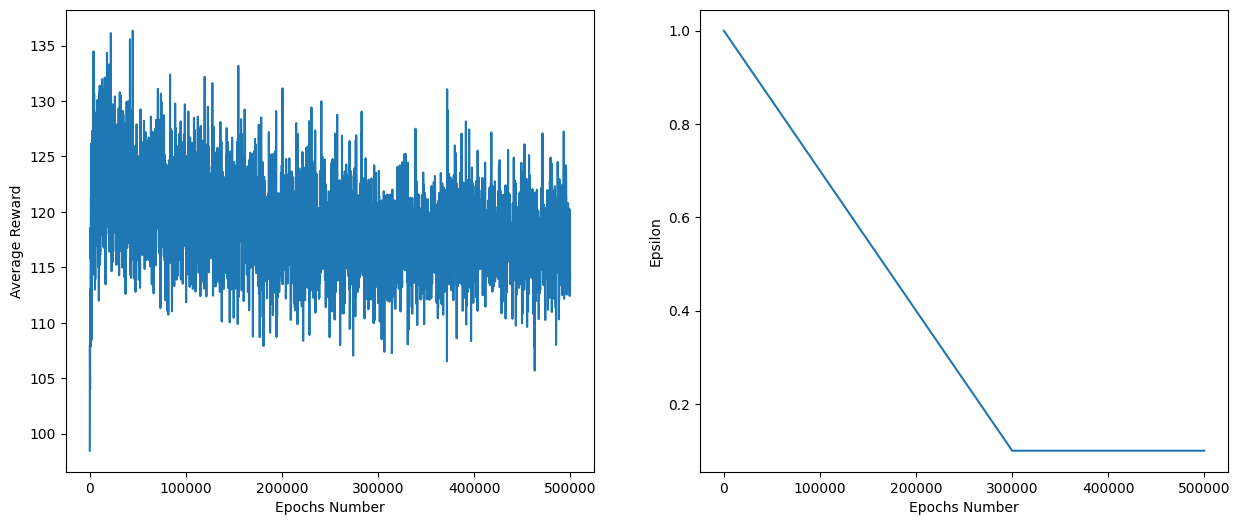

training finished.



In [40]:
# Hyperparameters
alpha = 0.06
gamma = 0.6
epsilon = 0.1
min_difference = 0.000001 # 10^-7
td_step = 14

if train:
    double_q_learning_train(alpha=alpha,gamma=gamma,epsilon=epsilon, TD_step=td_step,min_q_diff=min_difference,env=env_aa)

## Q-Learning performance evaluation

In [41]:
avg_reward_aa = policy_eval(env=env_aa)

Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 117.02


## Q_table visualization

In [42]:
save_q_table(env_aa,table_name='q_table_aa', dir_name=directory_name)

### Statistics

In [43]:
q_table = []
with open('trials/' + directory_name + '/' + 'q_table_aa' + '.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)
    for row in csv_reader:
        converted_row = [float(element) for element in row[1:]]
        q_table.append(converted_row)

print(q_table)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 13.501576098736582, 18.962609066154812, 20.05481340036541, 15.069494109538574, 22.162951490469787, 20.12425507629419, 17.18571409295532, 19.49843309562854, 12.541087681466834, 13.738828971353858, 9.67259074731135, 16.047374304251257, 17.157275591137356, 16.09039326598969], [0.0, 13.638126193842938, 18.64352329935369, 19.747804127579982, 15.026624399533132, 23.38648828477581, 18.467091454182935, 17.138121461067733, 19.563524654487118, 11.808456580689853, 13.71966459658039, 9.733541798850558, 16.96665173718008, 17.708557136891066, 16.274223031822448], [0.0, 13.821481180078411, 18.38880363381743, 19.115476806010783, 14.908687524829292, 23.78742634919677, 22.046018466234774, 16.81569164836278, 19.219532368380296, 12.12332576790337, 13.974242805197246, 10.050202731419397, 17.238975560523137, 17.618077509118805, 16.63255968275434], [0.0, 14.159369929658034, 19.34012021025212, 19.104315290696128, 14.6584848445

In [44]:
action = None
count = {}
for a in ACTIONS:
    count[a]=0
for row in q_table:
    #print(row)
    if not max(row) == 0:
        action = row.index(max(row))
        #print(action)
        count[unparse_action(action)] += 1
    #print(count)

print(count)

{'none': 0, 'attack': 0, 'scolding': 0, 'intimidate': 0, 'grudge': 0, 'sharing_happiness': 91, 'happy_person': 13, 'satisfaction': 0, 'sharing_fear': 0, 'running_away': 0, 'sharing_sadness': 0, 'disappointment': 0, 'surprise': 0, 'disbelief': 0, 'astonishment': 0}


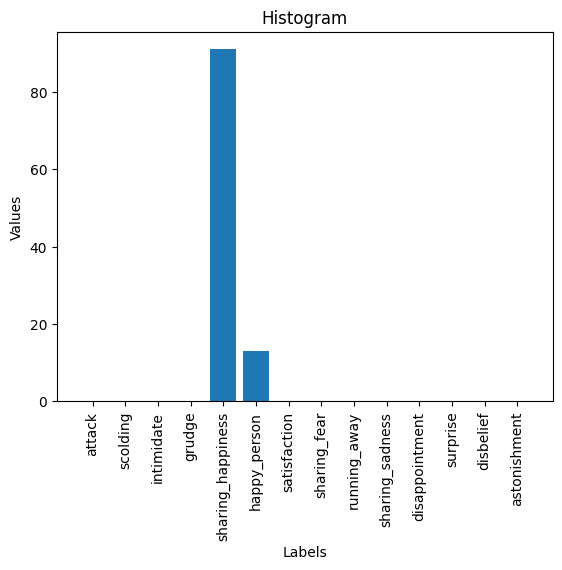

In [45]:
labels = list(count.keys())[1:]
values = list(count.values())[1:]

plt.bar(labels, values)
plt.xlabel('Labels')
plt.ylabel('Values')
plt.title('Histogram')
plt.xticks(rotation=90)
plt.savefig('graphs/'+ 'hist_aa_' + directory_name + '.png')
plt.show()

# Action-per-Emotion Model

### Load P action per emotion matrix

In [46]:
with open('P_action_per_emotion.json') as f:
    P_ae = json.load(f)

print(P_ae)

# convert keys into numbers
new_P = {}
for k in P_ae.keys():
    new_P[int(k)]=P_ae[k]

P_ae = new_P
print(P_ae)

{'1': [[0.15384615384615385, 3, 6], [0.07692307692307693, 5, 4], [0.07692307692307693, 6, 4], [0.07692307692307693, 7, 0], [0.3076923076923077, 8, 7], [0.3076923076923077, 10, 2]], '2': [[0.06666666666666667, 2, 2], [0.1, 3, 4], [0.06666666666666667, 5, 1], [0.2, 6, 34], [0.03333333333333333, 7, 0], [0.1, 8, 11], [0.16666666666666666, 10, 19], [0.13333333333333333, 11, 3], [0.06666666666666667, 12, -2], [0.03333333333333333, 13, 6], [0.03333333333333333, 14, 3]], '3': [[0.019230769230769232, 1, -1], [0.07692307692307693, 2, 6], [0.07692307692307693, 3, 2], [0.038461538461538464, 4, 4], [0.07692307692307693, 5, 1], [0.17307692307692307, 6, 8], [0.07692307692307693, 7, 6], [0.038461538461538464, 8, 3], [0.23076923076923078, 10, 6], [0.11538461538461539, 11, 6], [0.019230769230769232, 12, 4], [0.057692307692307696, 14, 3]], '4': [[0.041666666666666664, 2, 3], [0.08333333333333333, 3, 1], [0.08333333333333333, 4, 0], [0.041666666666666664, 5, -1], [0.16666666666666666, 6, 0], [0.125, 8, -2

### Create action-per-emotion environment

In [47]:
env_ae = ImprobotEnv(actor_space=ACTIONS,robot_space=EMOTIONS,sketch_lenght=15,env_matrix=P_ae, P0=P0)

## Q-Learning off-policy TD(1) Training

Episode: 100
action choosen: 4
next_state: (1, 8)
q_value updated: -0.3983772836921878
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 168.46
Episode: 200
action choosen: 5
next_state: (3, 10)
q_value updated: 3.9664834211236966
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 157.63
Episode: 300
action choosen: 5
next_state: (3, 10)
q_value updated: 7.4597508973970195
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 165.48
Episode: 400
action choosen: 3
next_state: (2, 11)
q_value updated: 2.0229651693711523
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 168.79
Episode: 500
action choosen: 5
next_state: (3, 6)
q_value updated: 5.789463845964013
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 170.47
Episode: 600
action choosen: 4
next_state: (3, 10)
q_value updated:

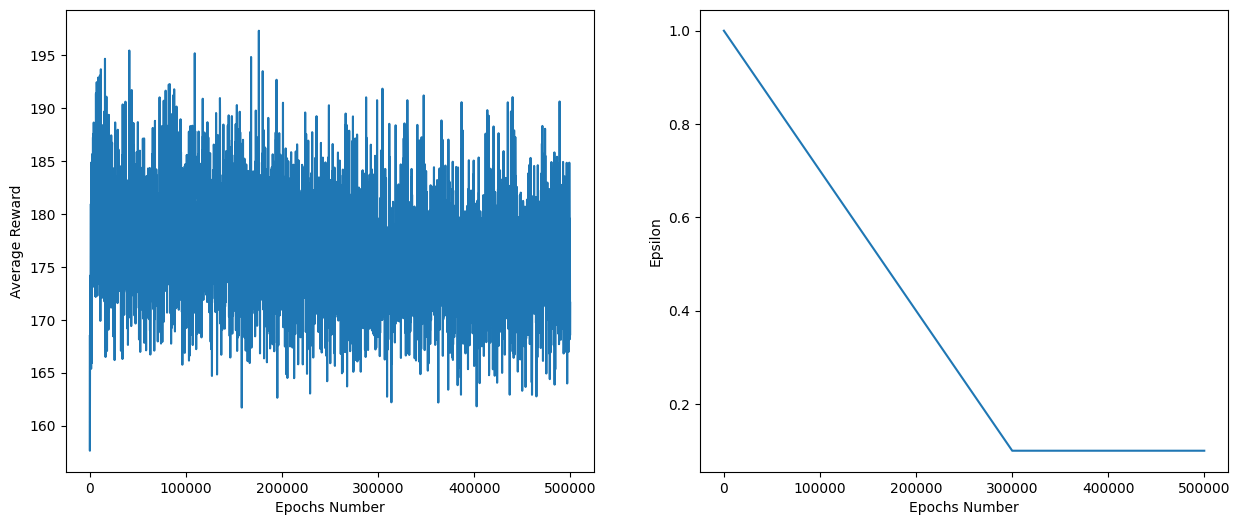

training finished.



In [48]:
# Hyperparameters
alpha = 0.06
gamma = 0.6
epsilon = 0.1
min_difference = 0.000001
td_step = 14

if train:
    double_q_learning_train(alpha=alpha,gamma=gamma,epsilon=epsilon, TD_step=td_step,min_q_diff=min_difference,env=env_ae)

## Q-Learning performance evaluation

In [49]:
avg_reward_ae = policy_eval(env=env_ae)

Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 182.9


## Q_table visualization

In [50]:
save_q_table(env_ae,table_name='q_table_ae', dir_name=directory_name)

### Statistics

In [51]:
q_table = []
with open('trials/' + directory_name + '/' + 'q_table_ae' + '.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)
    for row in csv_reader:
        converted_row = [float(element) for element in row[1:]]
        q_table.append(converted_row)

print(q_table)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 25.35836464043123, 31.779772325355072, 26.71862655820919, 18.560317517506412, 32.453758441930184], [0.0, 25.582996507195404, 32.86727425988859, 27.085842075850902, 18.65893828555572, 31.55390372303313], [0.0, 24.955497937619082, 33.11807677620419, 26.458323171282814, 18.576942785177188, 34.29393751435934], [0.0, 25.59641285911482, 30.354360852844867, 26.468876961388382, 18.894077209214785, 32.05526665725139], [0.0, 25.850504298117663, 29.896095964116412, 26.515637098631068, 19.37982590228691, 32.62131497821651], [0.0, 25.75019956564403, 35.986915256718696, 26.37211854971574, 18.36193394676508, 32.28378404315989], [0.0, 25.034300343081924, 32.134161581602285, 26.59273715982704, 18.728956545131318, 32.463850054362624], [0.0, 24.627126618606674, 35.395979473701374, 26.578248551352353, 19.05777034233878, 30.779483936651054], [0.0, 25.394560098160163, 35.74906683633422, 27.283924926192476, 18.636504984444578, 30.82131675893416], [0.0, 25.73877833121968

In [52]:
action = None
count = {}
for a in EMOTIONS:
    count[a]=0
for row in q_table:
    #print(row)
    if not max(row) == 0:
        emotion = row.index(max(row))
        #print(action)
        count[unparse_emotion(emotion)] += 1
    #print(count)

print(count)

{'none': 0, 'fear': 0, 'joy': 36, 'surprise': 0, 'sadness': 0, 'anger': 28}


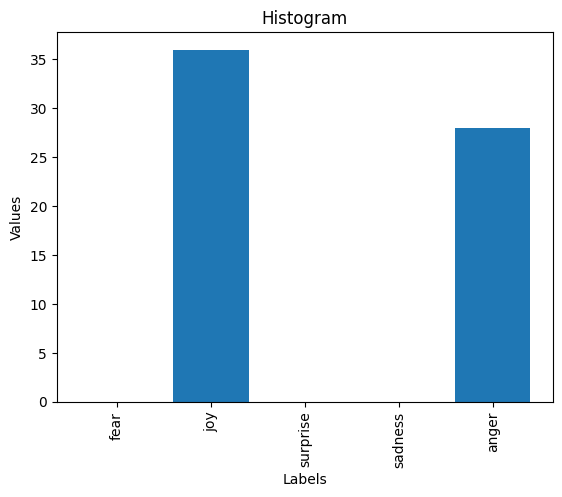

In [53]:
labels = list(count.keys())[1:]
values = list(count.values())[1:]

plt.bar(labels, values)
plt.xlabel('Labels')
plt.ylabel('Values')
plt.title('Histogram')
plt.xticks(rotation=90)
plt.savefig('graphs/'+ 'hist_ae_' + directory_name + '.png')
plt.show()

## Register results

In [54]:
#header = ["name", "avg_reward_aa", "avg_reward_ae"]
data = [directory_name, avg_reward_aa, avg_reward_ae]
with open('trials/summary.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    #writer.writerow(header)
    writer.writerow(data)